## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'segmentAnything-full' 
TRANSFORM = 'wavelet-horizontal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_horizontal_wavelet_full_segmentAnything.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'c:\\Users\\yashd\\Desktop\\hierarchical-bayesian-model-validation\\results\\case-studies\\segmentAnything\\full\\wavelet\\horizontal\\red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 7072,
 3: 28288,
 4: 113152,
 5: 452608,
 6: 1810432,
 7: 7241728,
 8: 28966912,
 9: 115867648,
 10: 463470592}

Running 12760 CDFs


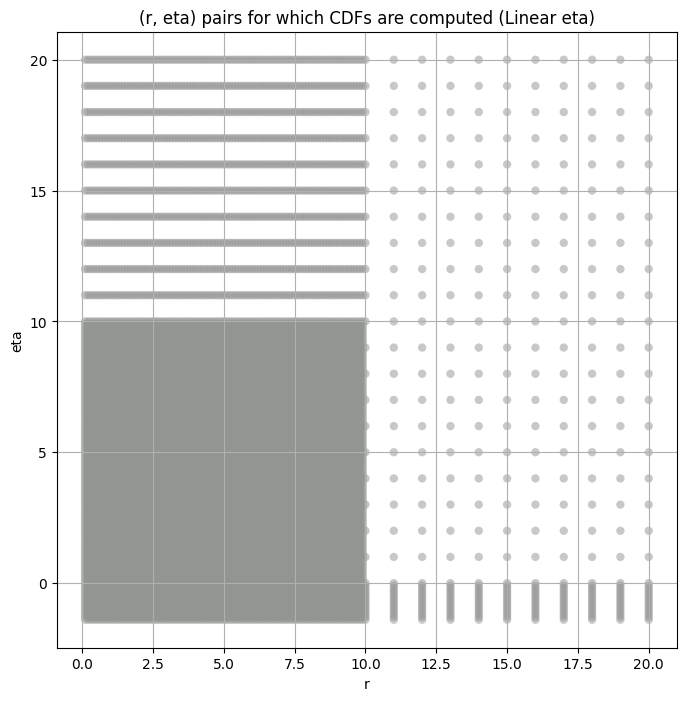

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      16568.330000  15498.675000  17678.645000   2.635927    2.156681   
3       3798.775000   3564.836200   4040.831300   3.901630    3.326615   
4        916.684900    852.525000    983.628900   5.594094    4.765932   
5        213.940960    197.560600    231.044340   7.429860    6.336338   
6         48.168140     44.092230     52.449684   9.292649    7.866127   
7         10.809623      9.840361     11.834001  11.065596    9.409023   
8          2.408565      2.178310      2.653160  12.751773   10.667212   
9          0.583217      0.525383      0.644653  13.878950   11.363679   
10         0.171274      0.154552      0.189357  13.258211   10.611671   

       kurt_upper  total_samples  
layer                             
2        3.145901           7072  
3        4.569647          28288  
4        6.494454         113152  
5        8.694106         452608  
6       10.931915        1810432  
7       12.970840        7241728  
8       15.278035       28966912  
9       16.987322      115867648  
10      16.273994      463470592

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      16568.330000   16568.330078    14731.616211    13576.545898   
3       3798.775000    3798.774902     3624.633545     3501.094971   
4        916.684900     916.684875      898.634888      883.954651   
5        213.940960     213.940964      208.884583      204.986328   
6         48.168140      48.168140       46.853683       45.847927   
7         10.809623      10.809623       10.485463       10.237060   
8          2.408565       2.408566        2.326901        2.265808   
9          0.583217       0.583217        0.561221        0.545148   
10         0.171274       0.171274        0.164685        0.159846   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2        12649.792969     11862.659180     10598.105469      9583.092773   
3         3393.964600      3300.140137      3136.544922      2993.396729   
4          871.046082       859.303101       838.312195       819.797729   
5          201.555130       198.428375       192.867264       187.932373   
6           44.969563        44.174625        42.763710        41.516014   
7           10.020367         9.824072         9.475037         9.167235   
8            2.212958         2.165418         2.081411         2.007952   
9            0.531433         0.519238         0.497930         0.479512   
10           0.155749         0.152135         0.145893         0.140563   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          8727.071289      7983.393066      7318.671875      5727.028809  
3          2869.140625      2757.144775      2654.296143      2390.316406  
4           803.070251       787.610840       773.122559       734.333496  
5           183.435257       179.292877       175.432220       165.193924  
6            40.388004        39.356647        38.400043        35.873760  
7             8.889666         8.636139         8.402027         7.787611  
8             1.942113         1.882181         1.827073         1.683474  
9             0.463144         0.448347         0.434810         0.399850  
10            0.135877         0.131679         0.127868         0.118150

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.07179765289848217 16568.33


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.07183656071645245 14731.616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.07188187349304676 13576.546


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.07187967386590532 12649.793


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07189518525634758 11862.659


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.07274785464162248 10598.105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.0727736856825924 9583.093


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.07366895786357491 8727.071


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.07524900715057103 7983.393


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.07754841222931286 7318.672


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.09450853420236094 5727.029
Number of samples: 7072, Without approximation : 7072


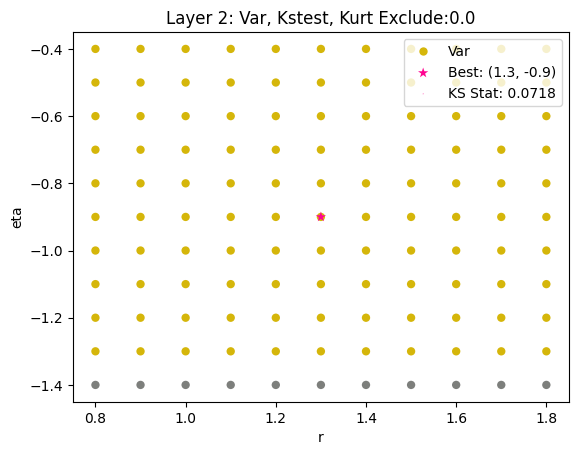

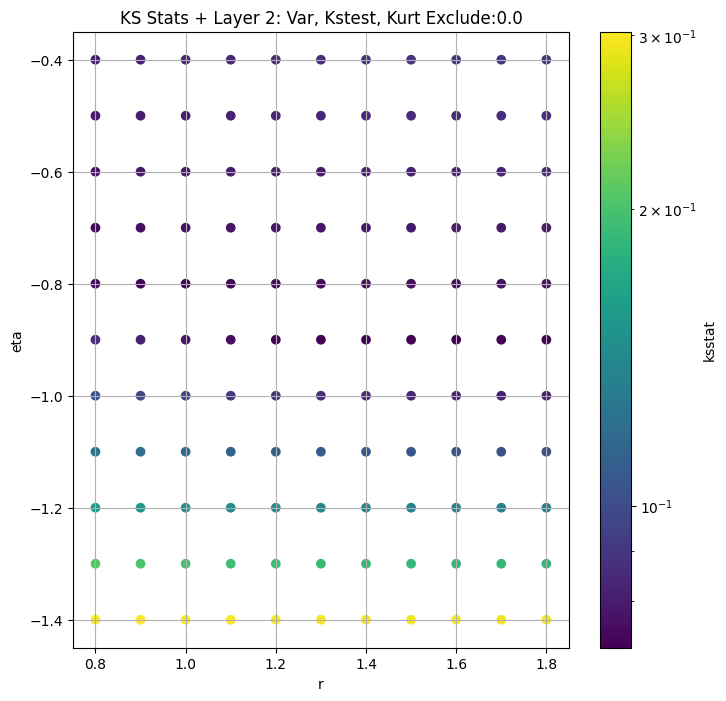

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.046846508105213014 3798.775


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.04672507686972588 3624.6335


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.04670297546844271 3501.095


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.046699376718210284 3393.9646


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.04671316206194759 3300.1401


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.04671086392019036 3136.545


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04710938461427816 2993.3967


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.048731028847825986 2869.1406


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.04986931669070449 2757.1448


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.05009549716609546 2654.2961


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.05015857933421408 2390.3164
Number of samples: 28288, Without approximation : 28288


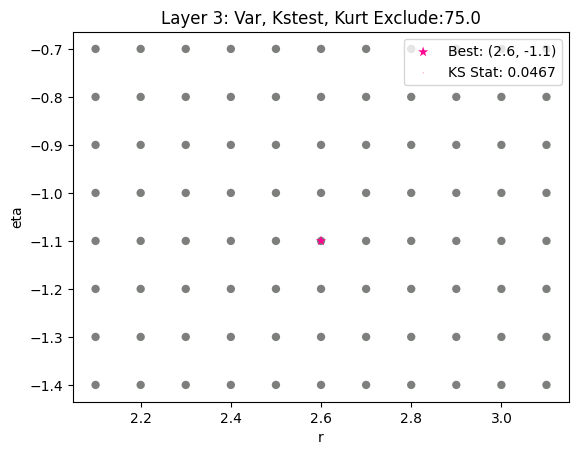

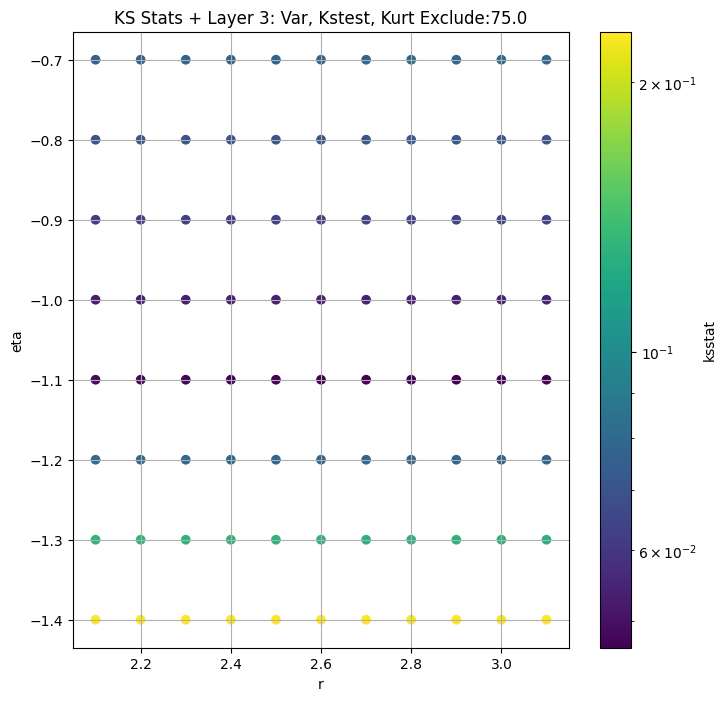

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.034016806177939285 916.6849


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.03399217363609852 898.6349


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.03397159687542356 883.95465


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.03395308389443147 871.0461


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.03393588887396498 859.3031


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.033932666687860824 838.3122


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.03392884562074433 819.7977


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.03392807215261029 803.07025


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.03392431930277778 787.61084


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.033922746087483746 773.12256


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.03391094415511148 734.3335
Number of samples: 100000, Without approximation : 113152


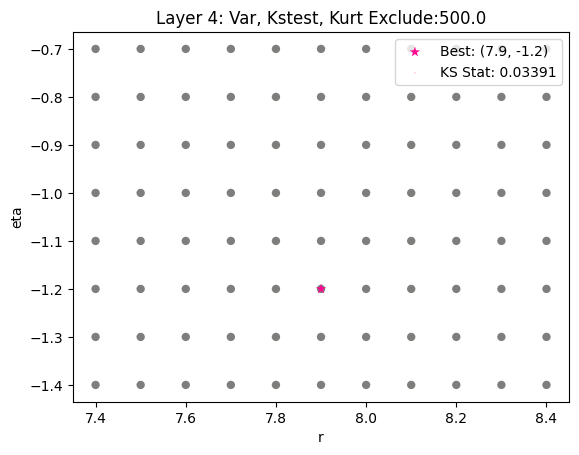

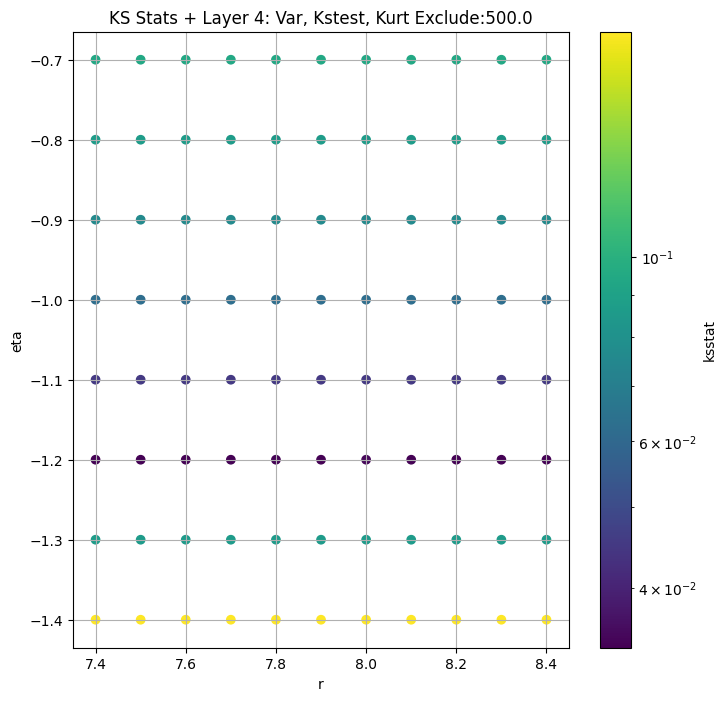

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.031044678340838905 213.94096


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.030994406134928765 208.88458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.030954402618846077 204.98633


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.03091824937964277 201.55513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.030884502266323555 198.42838


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.030824312562204192 192.86726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.030776468416277902 187.93237


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.030731215288896607 183.43526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.03106247665627393 179.29288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.030944901836129413 175.43222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.030594306042384223 165.19392
Number of samples: 100000, Without approximation : 452608


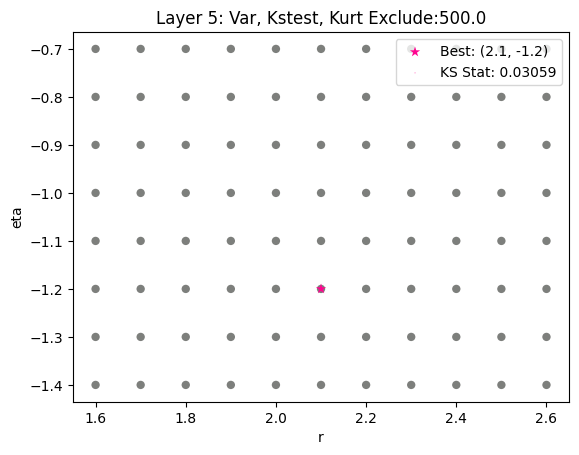

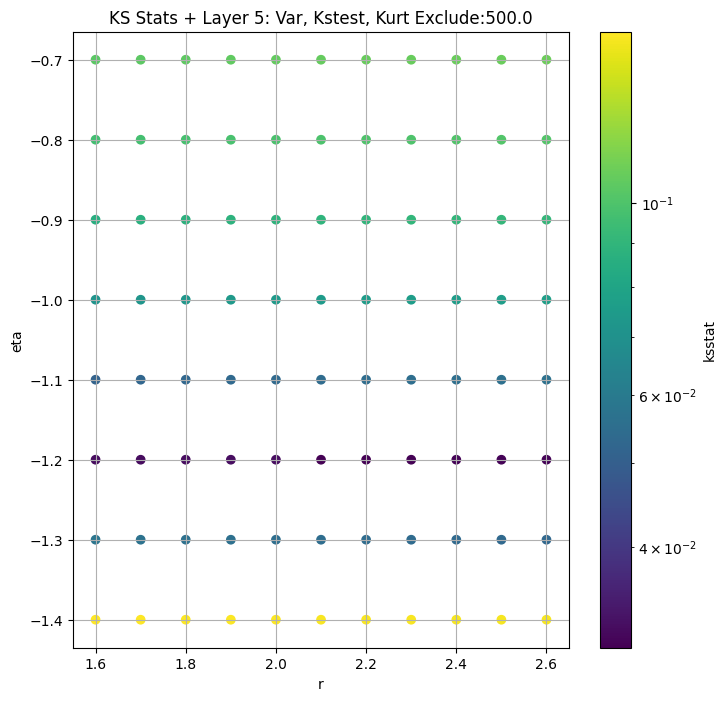

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.04134999999999983 48.16814


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.04134999999999983 46.853683


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.04134999999999983 45.847927


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.04134999999999983 44.969563


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.04134999999999983 44.174625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.04134999999999983 42.76371


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.04134999999999983 41.516014


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.04134999999999983 40.388004


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.04134999999999983 39.356647


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.04134999999999983 38.400043


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.04134999999999989 35.87376
Number of samples: 100000, Without approximation : 1810432


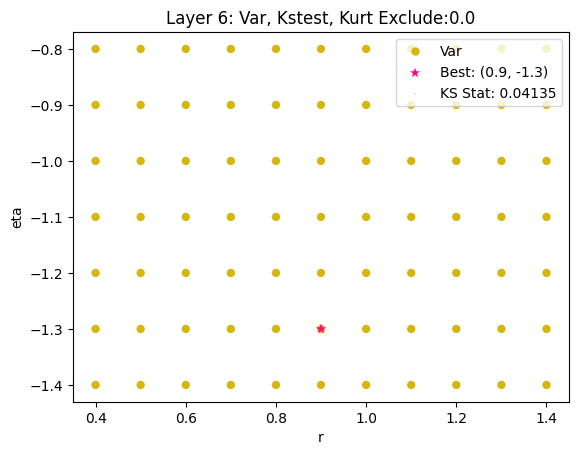

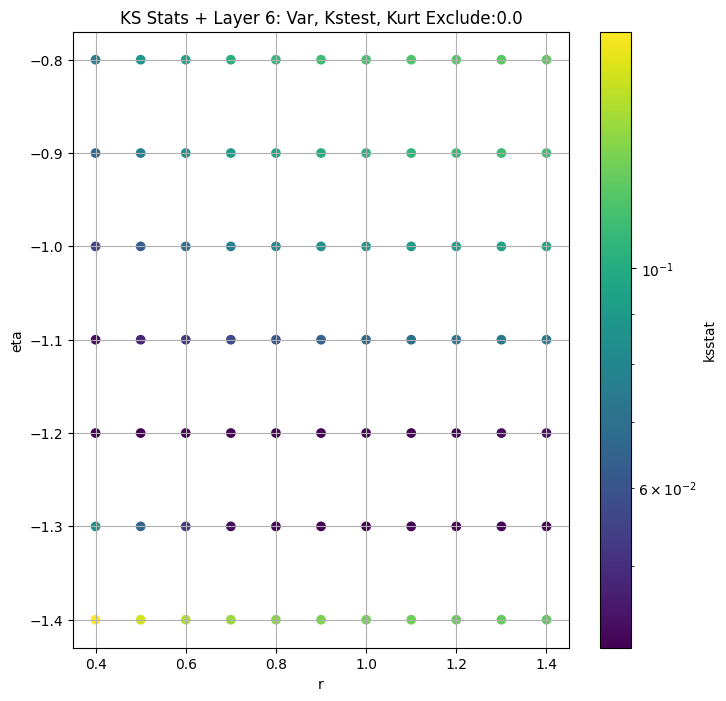

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.07346999999999981 10.809623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.07346999999999981 10.485463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.07346999999999981 10.23706


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.07346999999999981 10.020367


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.07346999999999981 9.824072


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.07346999999999981 9.475037


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.07346999999999981 9.167235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.07346999999999981 8.889666


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.07346999999999981 8.636139


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.07346999999999981 8.402027


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.07346999999999981 7.7876105
Number of samples: 100000, Without approximation : 7241728


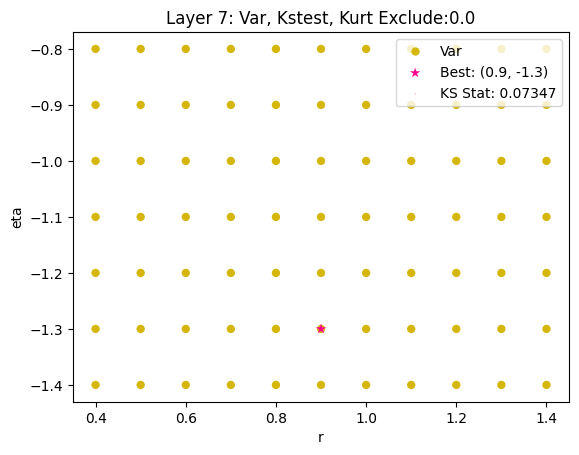

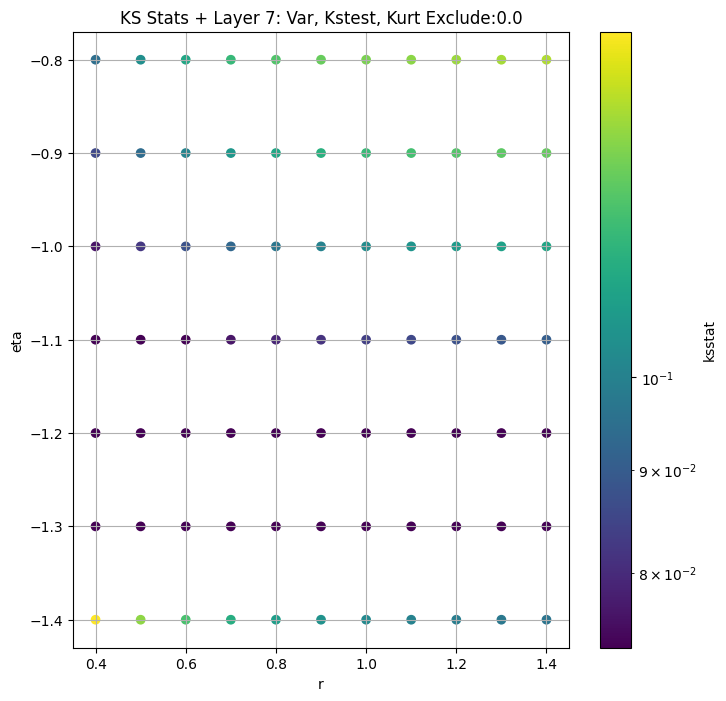

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.1193099999999998 2.4085655


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.1193099999999998 2.3269007


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.1193099999999998 2.265808


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.1193099999999998 2.2129579


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.1193099999999998 2.1654184


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.1193099999999998 2.081411


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.1193099999999998 2.0079517


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.1193099999999998 1.9421134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.1193099999999998 1.8821809


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.1193099999999998 1.8270726


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.1193099999999998 1.6834741
Number of samples: 100000, Without approximation : 28966912


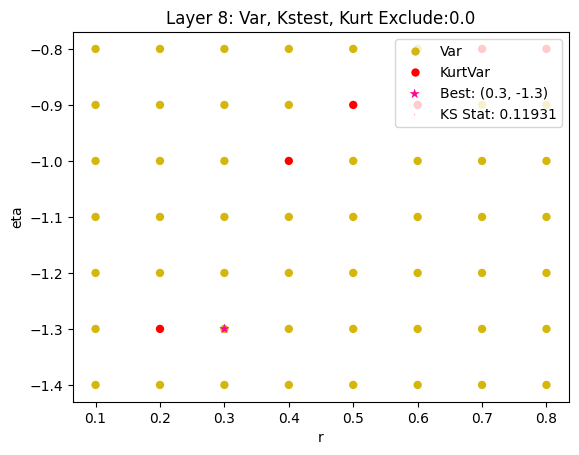

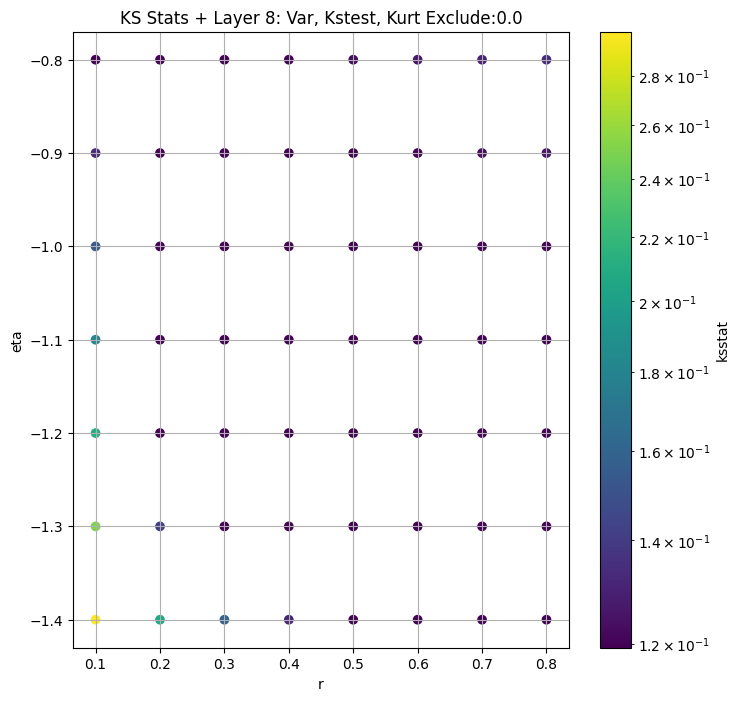

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.16943999999999976 0.58321714


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.16943999999999976 0.56122077


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.16943999999999976 0.54514813


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.16943999999999976 0.53143275


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.16943999999999976 0.5192377


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.16943999999999976 0.4979301


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.16943999999999976 0.47951216


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.16943999999999976 0.4631439


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.16943999999999976 0.44834656


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.16943999999999976 0.43481


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.16943999999999976 0.39984995
Number of samples: 100000, Without approximation : 115867648


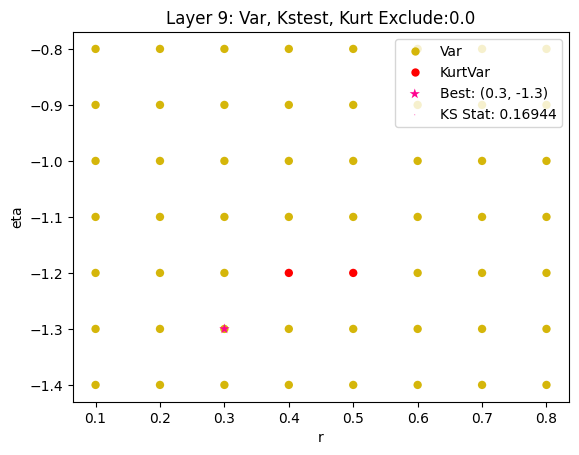

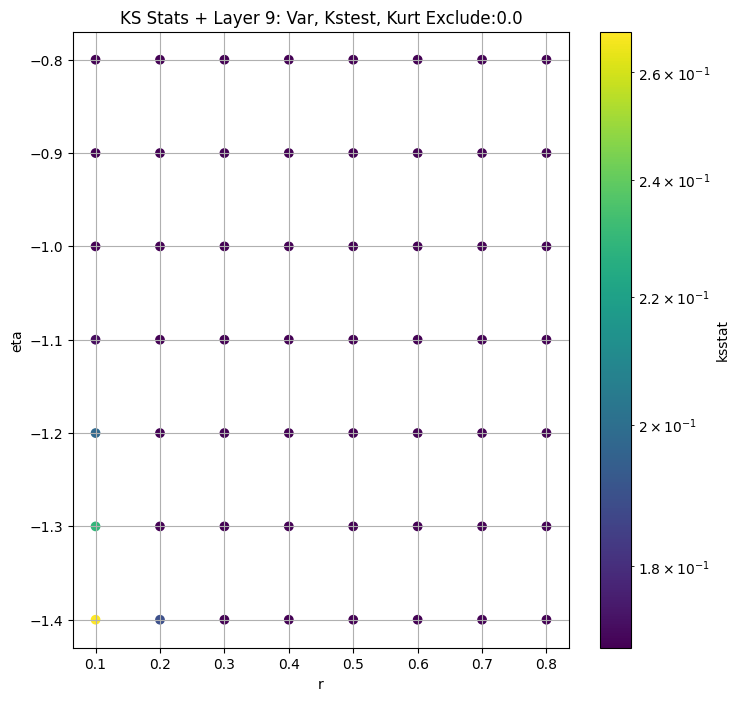

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.2188799999999998 0.17127426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.2188799999999998 0.16468538


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.2188799999999998 0.15984574


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.2188799999999998 0.15574895


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.2188799999999998 0.15213506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.2188799999999998 0.14589322


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.2188799999999998 0.14056301


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.2188799999999998 0.13587673


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.2188799999999998 0.13167872


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.2188799999999998 0.12786771


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.2188799999999998 0.11814997
Number of samples: 100000, Without approximation : 463470592


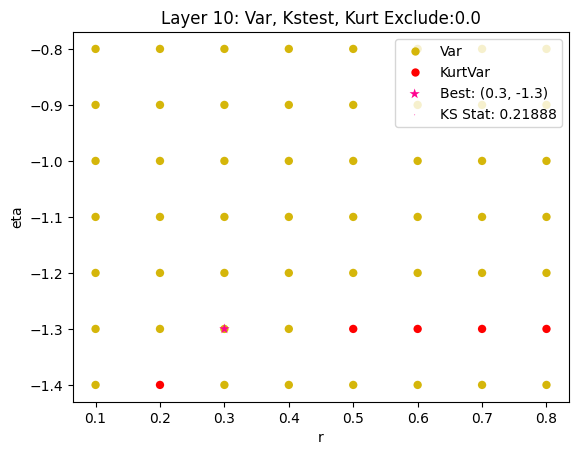

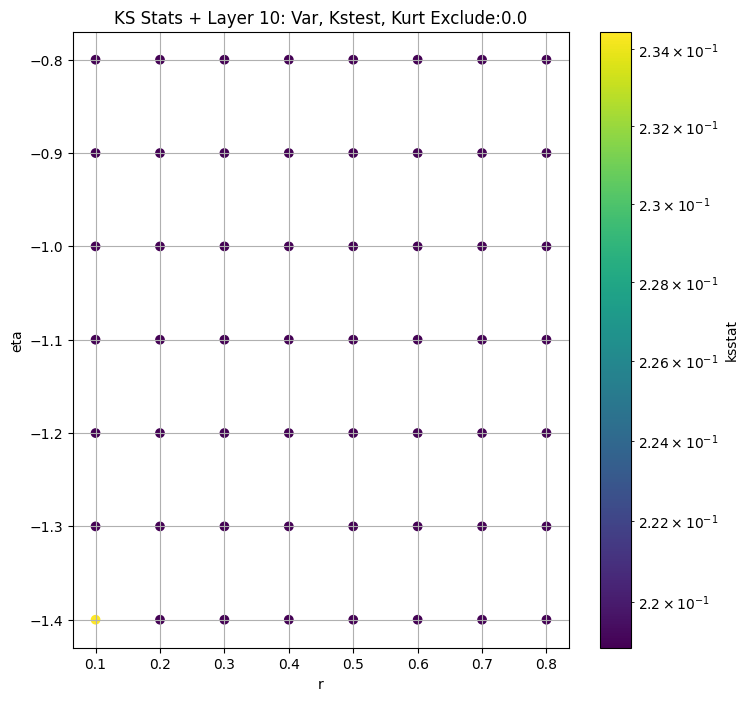

obs_var     var_lower     var_upper   obs_kurt  kurt_lower  \
layer                                                                    
2      16568.330000  15498.675000  17678.645000   2.635927    2.156681   
3       3798.775000   3564.836200   4040.831300   3.901630    3.326615   
4        916.684900    852.525000    983.628900   5.594094    4.765932   
5        213.940960    197.560600    231.044340   7.429860    6.336338   
6         48.168140     44.092230     52.449684   9.292649    7.866127   
7         10.809623      9.840361     11.834001  11.065596    9.409023   
8          2.408565      2.178310      2.653160  12.751773   10.667212   
9          0.583217      0.525383      0.644653  13.878950   11.363679   
10         0.171274      0.154552      0.189357  13.258211   10.611671   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        3.145901           7072             0.071798        1.3         -0.9   
3        4.569647          28288             0.046699        2.6         -1.1   
4        6.494454         113152             0.033911        7.9         -1.2   
5        8.694106         452608             0.030594        2.1         -1.2   
6       10.931915        1810432             0.041350        0.9         -1.3   
7       12.970840        7241728             0.073470        0.9         -1.3   
8       15.278035       28966912             0.119310        0.3         -1.3   
9       16.987322      115867648             0.169440        0.3         -1.3   
10      16.273994      463470592             0.218880        0.3         -1.3   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       34913.423718                     0.0        16568.330000   
3       12463.417165                    75.0         3393.964600   
4        3357.217677                   500.0          734.333500   
5         747.513386                   500.0          165.193920   
6         221.512698                     0.0           48.168140   
7          49.710632                     0.0           10.809623   
8           0.543580                     0.0            2.408565   
9           0.131624                     0.0            0.583217   
10          0.038654                     0.0            0.171274   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.016126  
3                     0.008069  
4                     0.004036  
5                     0.002018  
6                     0.001009  
7                     0.000505  
8                     0.000252  
9                     0.000126  
10                    0.000063

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.07263267737679724, var: 11862.6591796875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.07241105600784348, var: 12649.79296875


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.07214561735452302, var: 13576.5458984375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.07182717860892807, var: 14731.6162109375


  0%|          | 0/1800 [00:00<?, ?it/s]

Finding Minimum after computing 1800 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.07154322113816192, var: 16568.330078125
Number of samples: 7072, Without approximation : 7072


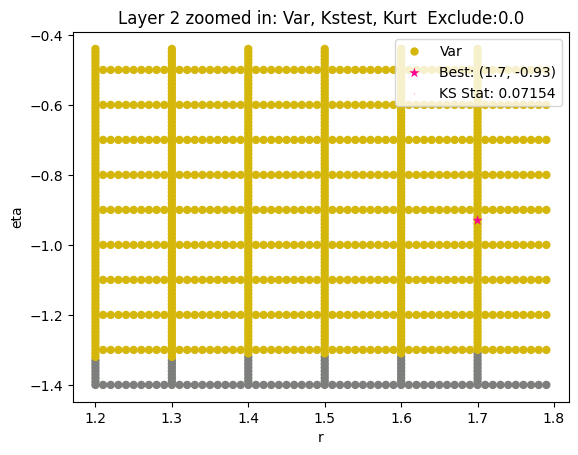

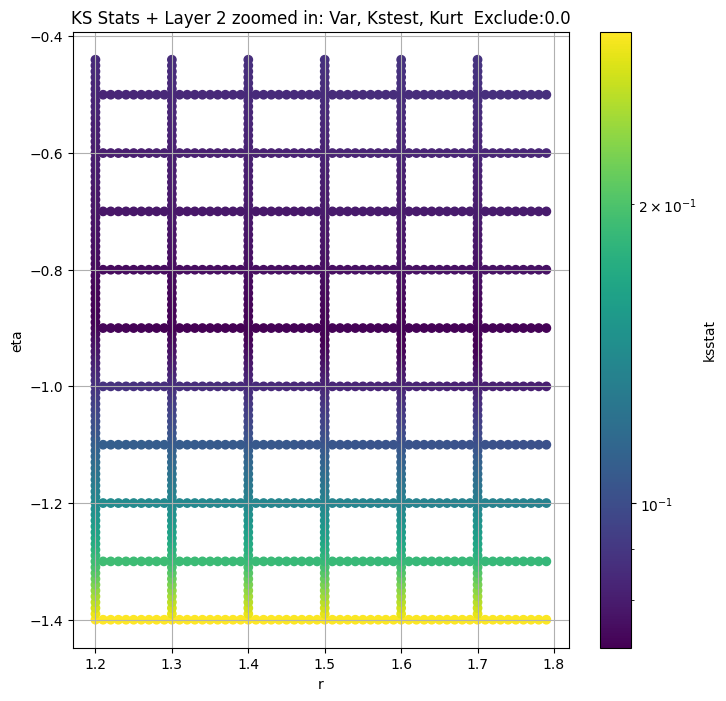

Layer 3


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + 100 = 175, ksstat: 0.04707750142317724, var: 3062.28125


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + 75 = 150, ksstat: 0.04710908793569524, var: 3136.544921875


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + 50 = 125, ksstat: 0.047158585513859985, var: 3214.92138671875


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + 25 = 100, ksstat: 0.04687038735006066, var: 3300.14013671875


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + 0 = 75, ksstat: 0.046699376718210284, var: 3393.964599609375


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + -25 = 50, ksstat: 0.04670297546844271, var: 3501.094970703125


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + -50 = 25, ksstat: 0.04671542666506512, var: 3624.633544921875


  0%|          | 0/149 [00:00<?, ?it/s]

Finding Minimum after computing 149 CDFs
layer 3, 75.0 + -75 = 0, ksstat: 0.04666134380601228, var: 3798.77490234375
Number of samples: 28288, Without approximation : 28288


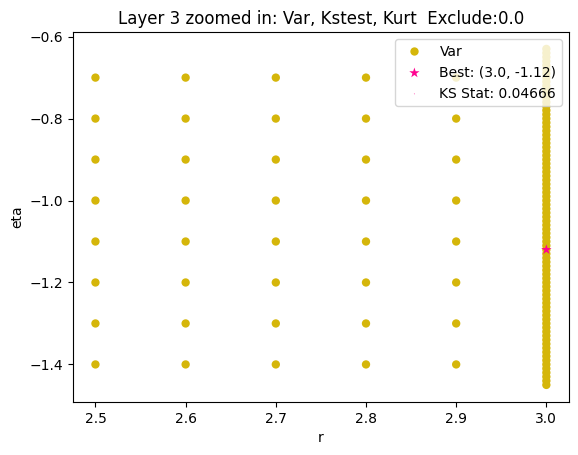

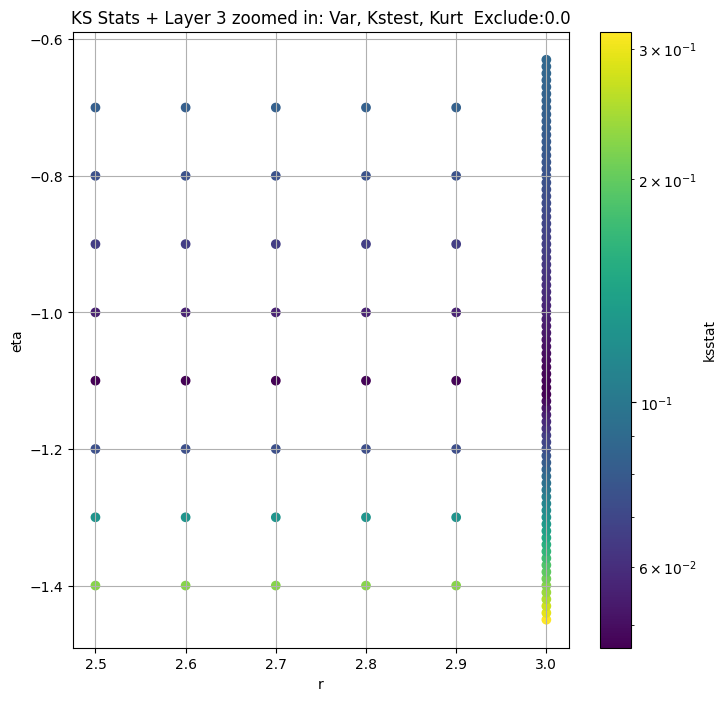

Layer 4


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + 100 = 600, ksstat: 0.034774086663161397, var: 711.6223754882812


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + 75 = 575, ksstat: 0.034551967180049714, var: 717.1043090820312


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + 50 = 550, ksstat: 0.03432599891767707, var: 722.7350463867188


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + 25 = 525, ksstat: 0.034098207992068086, var: 728.466796875


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + 0 = 500, ksstat: 0.03391094415511148, var: 734.33349609375


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + -25 = 475, ksstat: 0.0339163244300798, var: 740.364013671875


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + -50 = 450, ksstat: 0.03392241504475341, var: 746.5636596679688


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + -75 = 425, ksstat: 0.03392857224597917, var: 752.9100341796875


  0%|          | 0/131 [00:00<?, ?it/s]

Finding Minimum after computing 131 CDFs
layer 4, 500.0 + -100 = 400, ksstat: 0.03393761698693687, var: 759.4465942382812
Number of samples: 100000, Without approximation : 113152


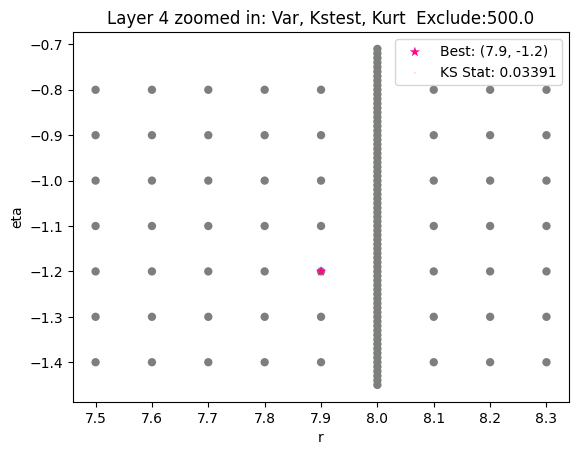

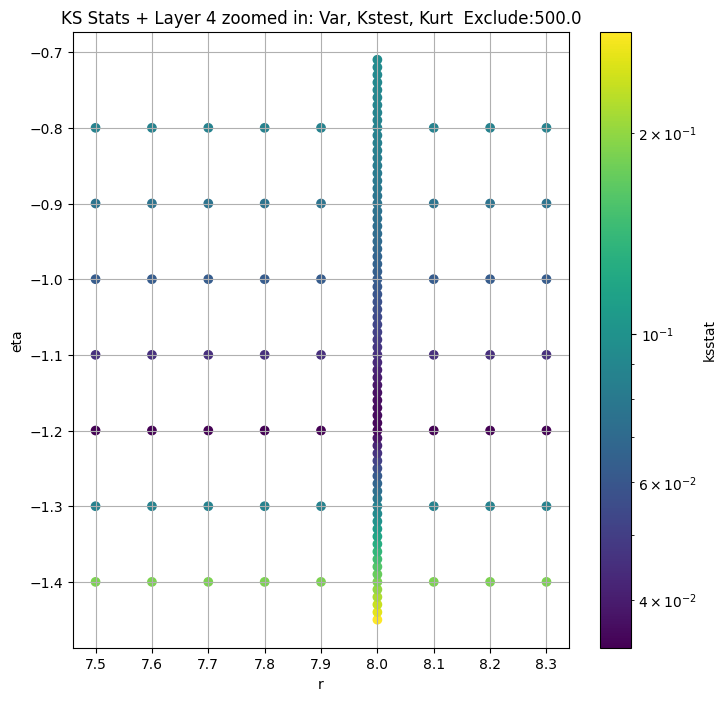

Layer 5


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + 100 = 600, ksstat: 0.02952999999999989, var: 159.2147979736328


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + 75 = 575, ksstat: 0.02952999999999989, var: 160.6592254638672


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + 50 = 550, ksstat: 0.02952999999999989, var: 162.13771057128906


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + 25 = 525, ksstat: 0.02952999999999989, var: 163.64776611328125


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + 0 = 500, ksstat: 0.02952999999999989, var: 165.1939239501953


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + -25 = 475, ksstat: 0.02952999999999989, var: 166.78028869628906


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + -50 = 450, ksstat: 0.02952999999999989, var: 168.4096221923828


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + -75 = 425, ksstat: 0.02952999999999989, var: 170.08656311035156


  0%|          | 0/587 [00:00<?, ?it/s]

Finding Minimum after computing 587 CDFs
layer 5, 500.0 + -100 = 400, ksstat: 0.02952999999999989, var: 171.81109619140625
Number of samples: 100000, Without approximation : 452608


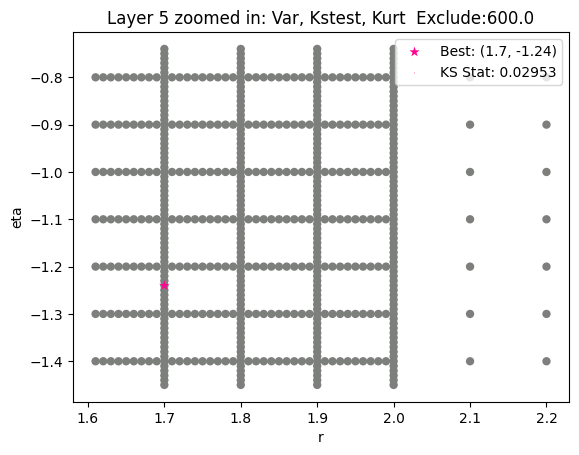

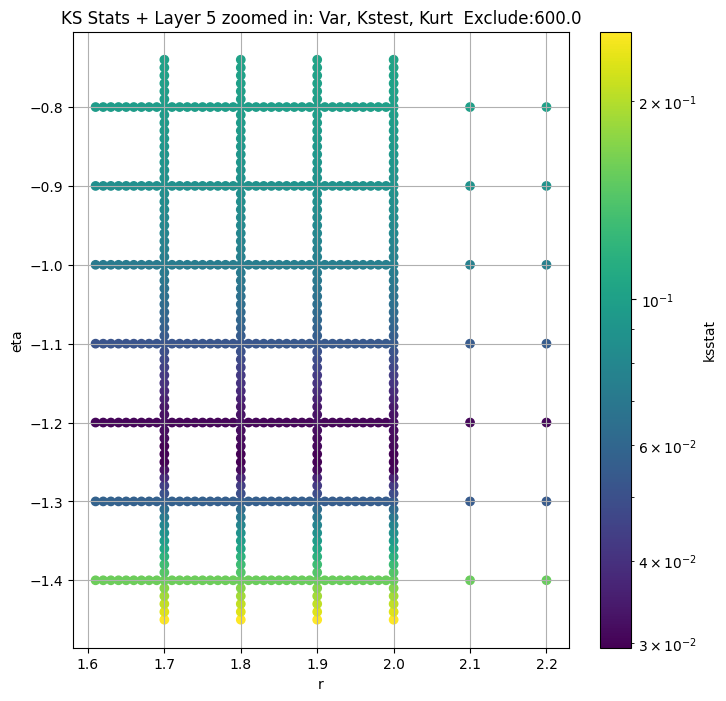

Layer 6


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 6, 0.0 + 100 = 100, ksstat: 0.041349999999999776, var: 44.174625396728516


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 6, 0.0 + 75 = 75, ksstat: 0.041349999999999776, var: 44.96956253051758


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 6, 0.0 + 50 = 50, ksstat: 0.041349999999999776, var: 45.84792709350586


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 6, 0.0 + 25 = 25, ksstat: 0.041349999999999776, var: 46.85368347167969


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 6, 0.0 + 0 = 0, ksstat: 0.041349999999999776, var: 48.16814041137695
Number of samples: 100000, Without approximation : 1810432


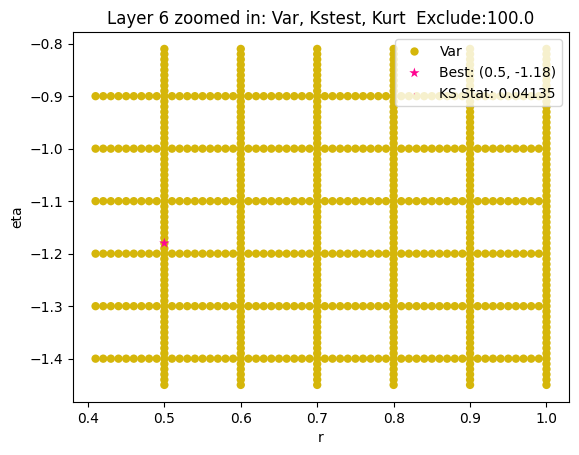

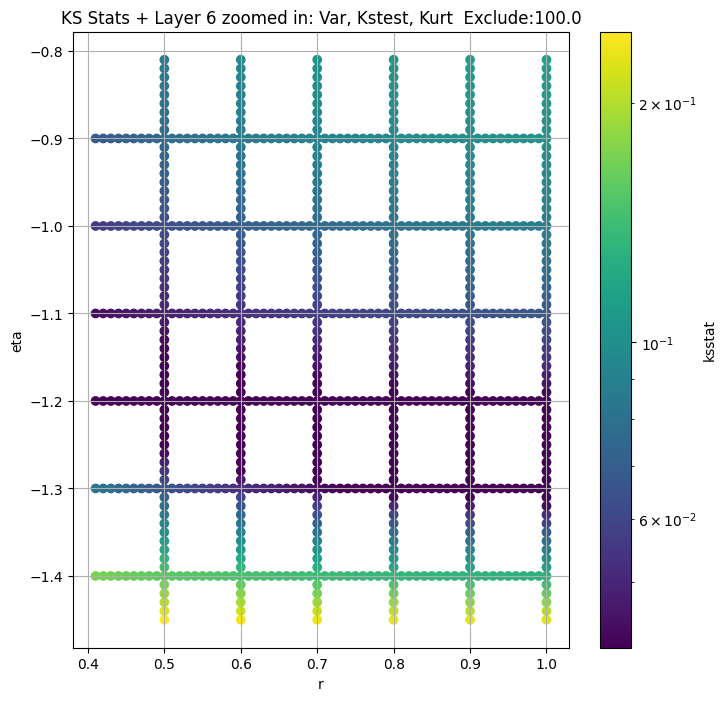

Layer 7


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.07346999999999976, var: 9.824071884155273


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.07346999999999976, var: 10.020366668701172


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.07346999999999976, var: 10.237059593200684


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.07346999999999976, var: 10.48546314239502


  0%|          | 0/1190 [00:00<?, ?it/s]

Finding Minimum after computing 1190 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.07346999999999976, var: 10.809622764587402
Number of samples: 100000, Without approximation : 7241728


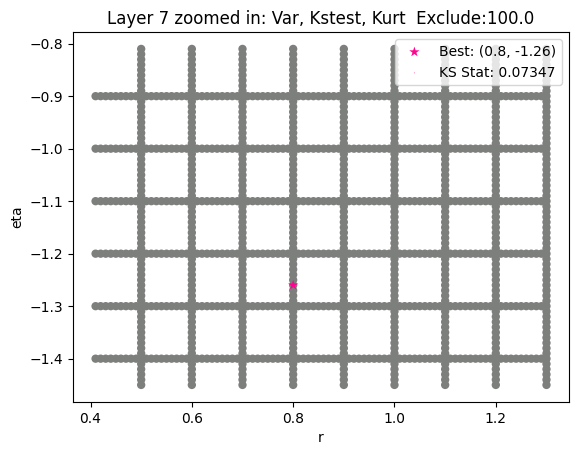

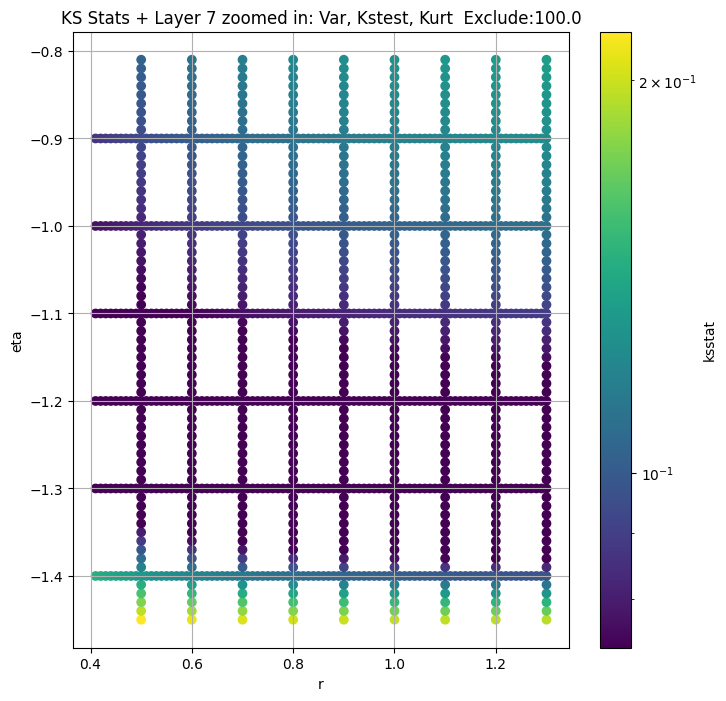

Layer 8


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.1193099999999998, var: 2.1654183864593506


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.1193099999999998, var: 2.2129578590393066


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.1193099999999998, var: 2.26580810546875


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.1193099999999998, var: 2.3269007205963135


  0%|          | 0/881 [00:00<?, ?it/s]

Finding Minimum after computing 881 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.1193099999999998, var: 2.4085655212402344
Number of samples: 100000, Without approximation : 28966912


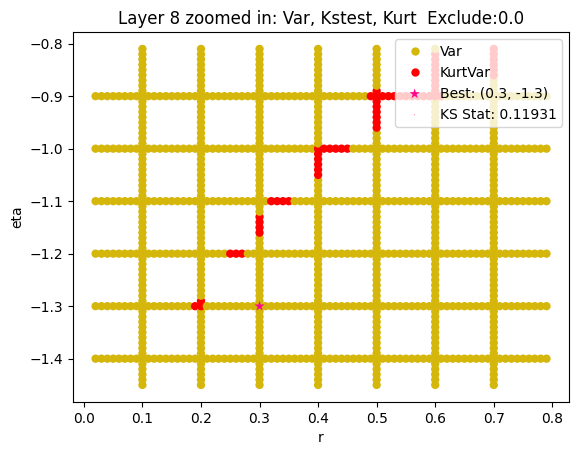

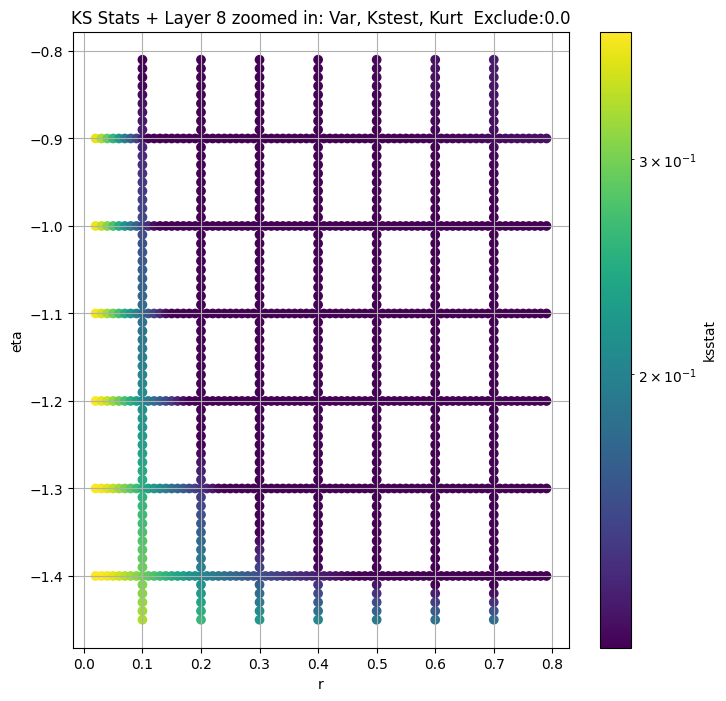

Layer 9


  0%|          | 0/881 [00:00<?, ?it/s]

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

In [ ]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [ ]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [ ]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

## Results

In [ ]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [ ]:
master_df.filter(regex="kstest_stat.*")

In [ ]:
master_df.filter(regex="best.*")

In [ ]:
eng.quit()